# Exercise 10.2-Reparametrizing Environment Maps (36 + 4 = 40 Points)
## Reflectance Fields
There are several environment maps in the *spheres* folder, shown in Figure 1, which are not in the correct format
for immediate use with the acquired reflectance field.
<br> Your job is to reparametrize them appropriately
and to use them for relighting afterwards. The section __reparametrize__ provides a skeleton implementation
to fll in. There are some things to keep in mind:
* Work on the pixels of the output map, otherwise you will end up with non-integer pixel positions
to write to, which is difficult.
* There is a function called `tp2xyz(theta, phi)` which will give you a properly rotated and scaled
vector which points into the direction of the light source for any given pair of angles $\theta$ and $\phi$.
*The resulting lighting direction vector $[D_x$  $D_y$  $D_z]$ has to be converted to texture coordinates in the
space of the original (spherical) environment map. This can be done according to the following
formula:


$$
\begin{align}
r= \frac{1}{\pi}\frac{{\arccos (D_z)}}{\sqrt[2]{D_x^2+D_y^2}}
\end{align}
$$

$$
\begin{align}
u = r D_x
\end{align}
$$

$$
\begin{align}
v = r D_y
\end{align}
$$

* u and v are then texture coordinates in the range $[-1...1]$ each, they have to be rescaled to range
 $[1...nPixels]$.

* Values taken from the original map should be bilinearly interpolated.

Note that the resulting polar map only represents a part of the original map, it covers $2\pi$ (360 degrees)
in the rotation direction $\phi$, but only $0.5\pi$ in elevation $\theta$. This is accounted for in the code by
rescaling *theta* and *phi* with $\pi/256$ in the beginning. If you change the output size, you must adapt these
scaling factors as well. Your results should look like Figure 2.

<figure style="text-align:center">
    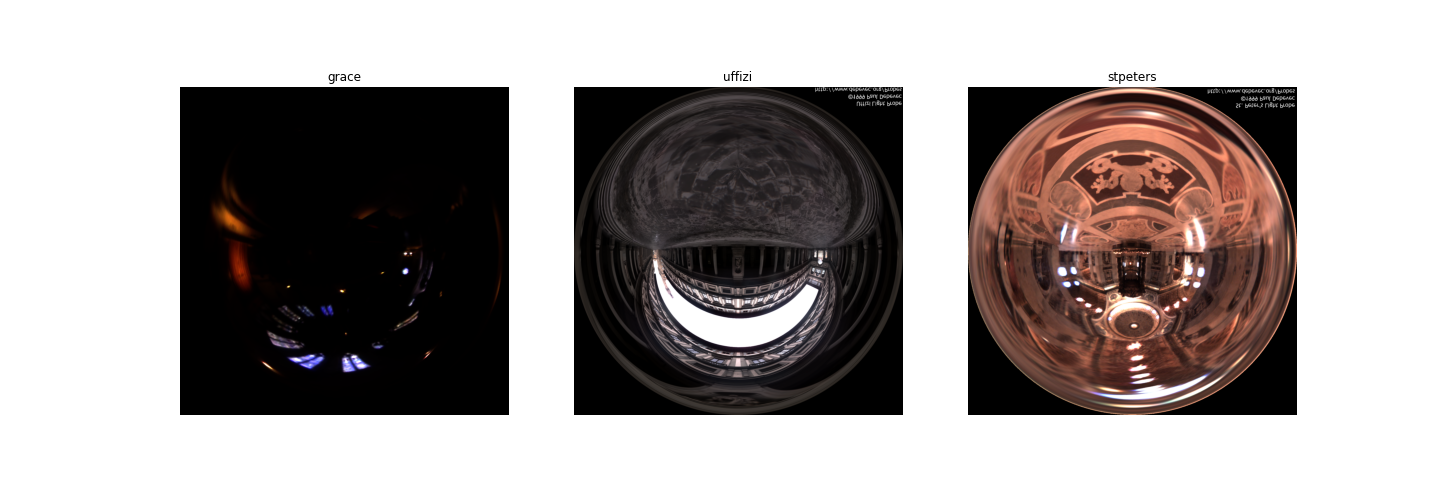
    <figcaption>Figure 1: Spherical environment maps: grace, uffizi, and stpeters.</figcaption>
</figure>




<figure style="text-align:center">
    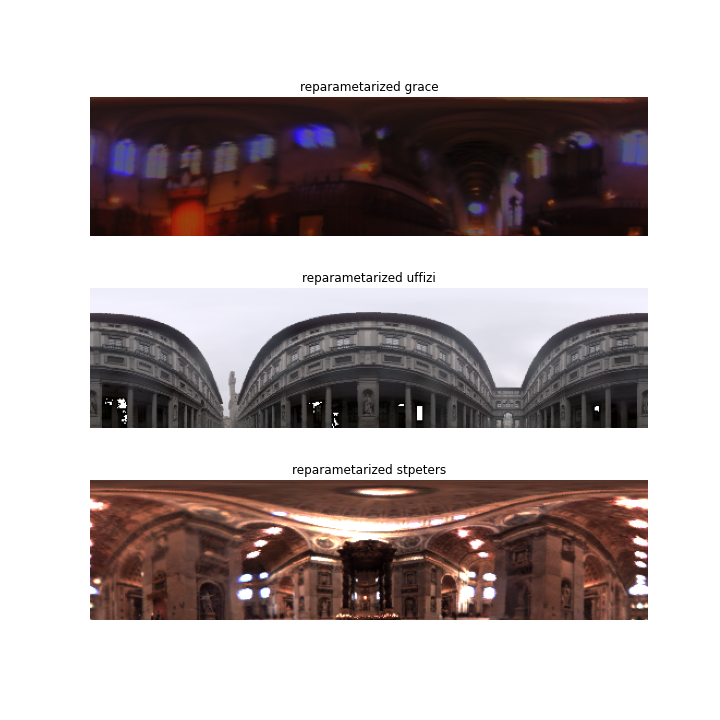
    <figcaption>Figure 2: Expected results (after tonemapping).</figcaption>
</figure>


In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import numpy as np
import math
import cv2
import struct
from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image

from Helper_functions import *

In [2]:
# Define paths:
rfPath="rf_bin"
envPath = "spheres"
resultPath="result_relighting"

## Reparametrizing Environment Maps
### a) (3+3+8+8+8+3+3 p)
Your task is to implement a function called `reparam()` that takes an environment map as its input and returns a correctly reparametrized map as its output. In order to complete this task, follow the steps below:<br><br>
1. Load the environment map.<br><br>
2. Loop over the output resolution, in our example [128, 512, 3] .   <br><br>
3. Scale by $\pi/256$ to get to $128/256*\pi=\pi/2$ and $512/256*\pi=2pi$. (Adapt for different output sizes).<br><br>
5. Determine the direction for this light position.<br><br>
5. Determine the texture coordinates on the sphere for the direction.<br><br>
6. Bilinearly interpolate from these texture coordinates.<br><br>
7. Retrieve the values from the environment map at the computed coordinate.<br><br>
8. Write the result to the output directory.<br><br>
9. Apply reparameterization on environment maps using your implemented `reparam()`.<br>
<br> <i>Hint</i>: The environment maps have different shapes, work at the output resolution as explained above.<br>
<br><b>TODO:</b><br>

In [3]:
from Helper_functions import import_bin_files

# Read in the environment maps
grace = import_bin_files(f"{envPath}/grace.bin")
stpeters = import_bin_files(f"{envPath}/stpeters.bin")
uffizi = import_bin_files(f"{envPath}/uffizi.bin")

In [209]:
# Implement the function reparam().

def reparam(env_map: np.ndarray) -> np.ndarray:
    ydim = 128
    xdim = 512
    out_image = np.zeros((ydim,xdim,3))
    
    for y in range(out_image.shape[0]):
        for x in range(out_image.shape[1]):
            theta = y * np.pi / (ydim * 2)
            phi = x * np.pi / (xdim / 2)
            
            D = tp2xyz(theta, phi)
            
            r = 1 / np.pi * np.arccos(D[2]) / np.sqrt(np.square(D[:2]).sum())
            
            u = r * D[1]
            v = r * D[0]
            u = (u + 1) * env_map.shape[1] / 2
            v = (v + 1) * env_map.shape[0] / 2
            
            # Bilinear interpolation
            u1 = int(np.floor(u))
            u2 = u1 + 1
            v1 = int(np.floor(v))
            v2 = v1 + 1
            
            value = 1 * (
                env_map[u1,v1] * (v2-v) * (u2-u)
                + env_map[u2,v1] * (v2-v) * (u-u1)
                + env_map[u1,v2] * (v-v1) * (u2-u)
                + env_map[u2,v2] * (v-v1) * (u-u1)
            )
            
            out_image[y,x] = value
            
    return out_image

In [210]:
# Apply reparameterization using your implemented reparam() here.
grace_reparam = reparam(grace)
stpeters_reparam = reparam(stpeters)
uffizi_reparam = reparam(uffizi)

## Visualization 
### b) (1 +1+2 p) 
To visualize your results properly, please tonemap them using functions
available in the cv2 library :<br>
* first create a tonemapper object e.g.       `tonemapper=cv2.createTonemap(float gamma)`
* apply tonemapping via .process() function:   `tonemapped_img=tonemapper.process(image)`
* you can find more about tonemapping with cv2 here: [tonemapping](https://docs.opencv.org/3.4/d8/d5e/classcv_1_1Tonemap.html)<br>

<br><b>TODO:<b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


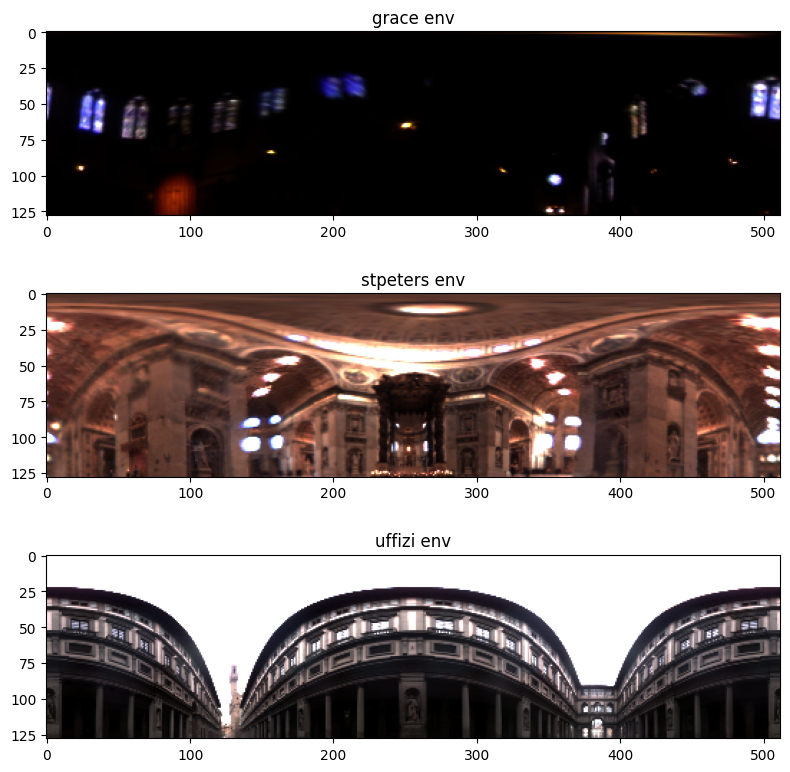

In [211]:
# Visualize the reparametrized environment maps here: 
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].imshow(grace_reparam)
ax[0].set_title("grace env")
ax[1].imshow(stpeters_reparam)
ax[1].set_title("stpeters env")
ax[2].imshow(uffizi_reparam)
ax[2].set_title("uffizi env")
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


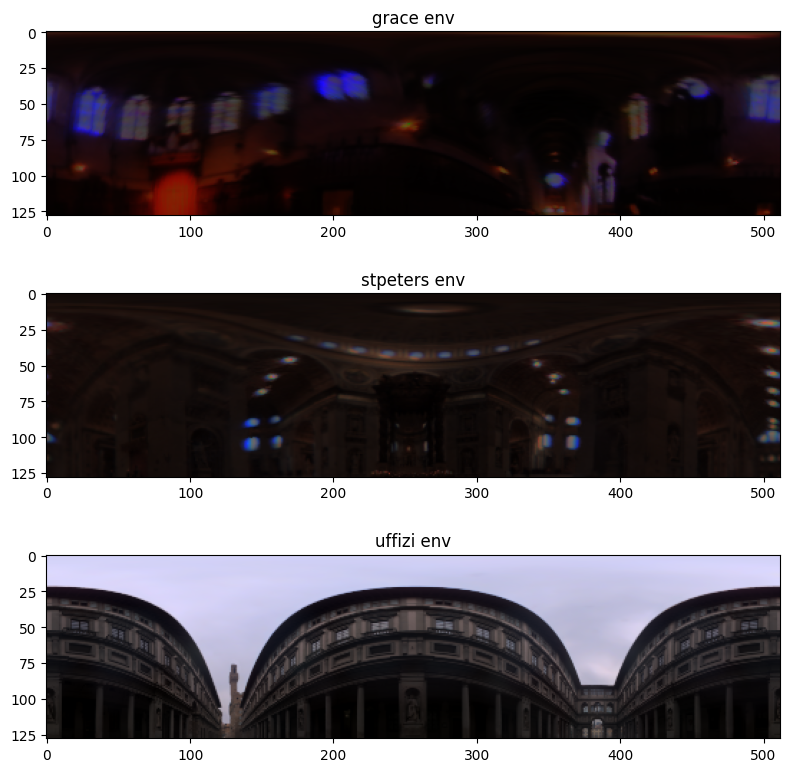

In [217]:
# Do tonemapping using cv2 library and visualize the tonemapped results here:
# You can simply use createTonemap or pick one of the variety of tonemaps available in cv2 like createTonemapDrago.
tonemapper = cv2.createTonemapDrago()

# Visualization of tonemapped images.
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].imshow(tonemapper.process(grace_reparam.astype(np.float32)+1e-12))
ax[0].set_title("grace env")
ax[1].imshow(tonemapper.process(stpeters_reparam.astype(np.float32)+1e-12))
ax[1].set_title("stpeters env")
ax[2].imshow(tonemapper.process(uffizi_reparam.astype(np.float32)+1e-12))
ax[2].set_title("uffizi env")
fig.tight_layout()



<figure style="text-align:center">
    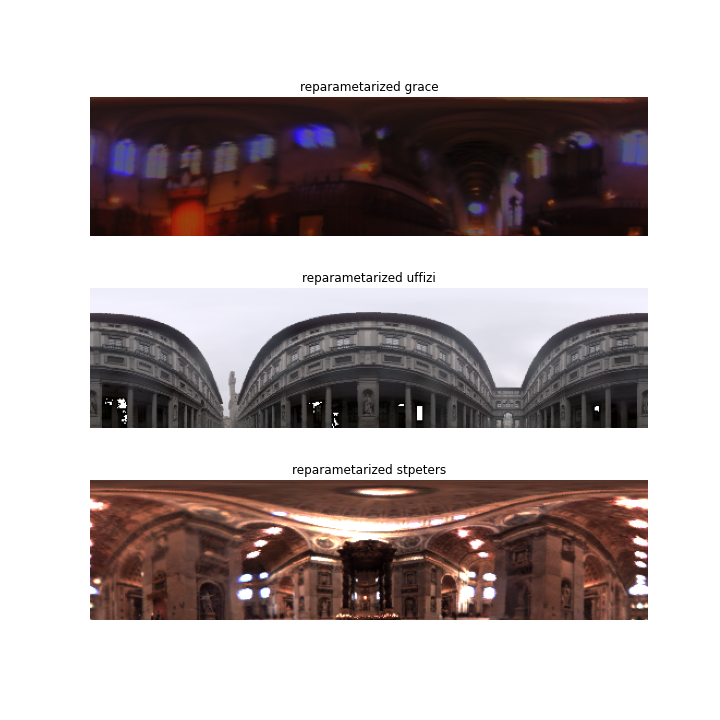
    <figcaption>Figure 2: Expected results (after tonemapping).</figcaption>
</figure>
